# Preparatory steps



In [1]:
# access data from the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# alternative: upload files
# from google.colab import files
# uploaded = files.upload()

### Installing necessary packages

Install the necessary bert packages and Tensorflow 1.15.2

In [2]:
!pip uninstall gast
!pip install gast==0.2.2
!pip install sentencepiece
!pip install bert-tensorflow==1.0.1
!pip install pandas==0.24

Uninstalling gast-0.3.3:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/gast-0.3.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/gast/*
Proceed (y/n)? y
  Successfully uninstalled gast-0.3.3
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=4ae1edbbc7c64591f207ba5d546a3118c87ce756864300c17792c9073945f968
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 1.2MB 32.6MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 10.1MB 29.1MB/s 
ERROR: xarray 0.18.0 has requirement pandas>=1.0, but you'll have pandas 0.24.0 which is incompatible.
ERROR: plotnine 0.6.0 

After restarting the runtime as suggested, run following:

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# for importing modules in .py files, insert the working directory
import sys
sys.path.insert(0,'/content/drive/My Drive/AIandLaw/CodeAndModel/')

# Train XGBoost

Split bert_features (full training_data_hate_speech.csv) to 0.75 training and 0.25 test dataset, split training dataset to training and validation datasets, get optimizatin hyperparameters, retrain with training dataset and test with test dataset, retrain with full dataset and get the model.

This file performs a hyperparameter optimization, train the best model on the full train set and reports
 performance on the test set and then retrains the same model on all data (train + test).
It needs the following input:
- data_path: Location of a dataset with the BERT features. These features have to be created with the
create_bert_dataset.py script. Because of the BERT models size it is a slow process to create these features and the
xgboost model will probably retrained with higher frequency than the BERT model, so I separated these two tasks.
- number_of_runs: Number of models that are trained during the hyperparameter optimization.
- optimization_output_path: Location where the results of the hyperparameter optimization are saved.
- final_model_path: Location where the xgboost model is saved.

### Preprocessing

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score, confusion_matrix, matthews_corrcoef
from sklearn.externals import joblib

from functions_modified import *

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# --------- User Input ----------------------------
data_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/bert_features.csv"
number_of_runs = 20
optimization_output_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/optimization_result.csv"
intermediate_model_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/intermediate_xgboost_model.dat"
final_model_path = "/content/drive/My Drive/AIandLaw/CodeAndModel/xgboost_model.dat"

In [5]:
# load data
data = pd.read_csv(data_path)

In [6]:
data.shape

(195066, 772)

In [7]:
bert_features = ["bert_" + str(i) for i in range(768)]

In [8]:
# validation split
X_train, X_test = train_test_split(data, test_size=0.25, random_state=25)
X_train, X_vali = train_test_split(X_train, test_size=0.25, random_state=25)
print("X_train.shape: {}".format(X_train.shape))
print("X_vali.shape: {}".format(X_vali.shape))
print("X_test.shape: {}".format(X_test.shape))

X_train.shape: (109724, 772)
X_vali.shape: (36575, 772)
X_test.shape: (48767, 772)


### Hyperparameter tuning and optimization

In [ ]:
hyper_list = []
n = 1
for i in range(number_of_runs):
    print("Training model {} out of {}".format(n, number_of_runs))
    learning_rate = np.random.uniform(0.001, 0.15)
    max_depth = np.random.choice([3, 4, 5, 6])
    n_estimators = np.random.randint(low=50, high=180)
    subsample = min(np.random.uniform(0.6, 1.1), 1.0)
    colsample_bytree = min(np.random.uniform(0.6, 1.1), 1.0)

    params = {'learning_rate': learning_rate,
              'max_depth': max_depth,
              'n_estimators': n_estimators,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree}
    print(params)

    xgb_model = xgb.XGBRegressor(learning_rate=learning_rate,
                                 objective='binary:logistic',
                                 random_state=25,
                                 n_jobs=8,
                                 n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 subsample=subsample,
                                 colsample_bytree=colsample_bytree)

    xgb_model.fit(X_train.loc[:, bert_features], X_train['Hateful_or_not'])

    # evaluation on validation set
    preds = xgb_model.predict(X_vali.loc[:, bert_features])
    fpr, tpr, _ = roc_curve(X_vali['Hateful_or_not'], preds)
    roc_auc = auc(fpr, tpr)
    params['roc'] = roc_auc

    hyper_list.append(pd.DataFrame(params, index=[0]))
    n = n + 1

Training model 1 out of 20
{'learning_rate': 0.11654324994198456, 'max_depth': 6, 'n_estimators': 50, 'subsample': 0.7159188763846641, 'colsample_bytree': 1.0}


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


Training model 2 out of 20
{'learning_rate': 0.02555694718485546, 'max_depth': 5, 'n_estimators': 124, 'subsample': 0.7237734192970305, 'colsample_bytree': 1.0}
Training model 3 out of 20
{'learning_rate': 0.08312197169332743, 'max_depth': 3, 'n_estimators': 116, 'subsample': 1.0, 'colsample_bytree': 0.9600536836771765}
Training model 4 out of 20
{'learning_rate': 0.019161831300245805, 'max_depth': 5, 'n_estimators': 104, 'subsample': 0.6270908484105385, 'colsample_bytree': 0.8265325140397789}
Training model 5 out of 20
{'learning_rate': 0.12682475798803633, 'max_depth': 5, 'n_estimators': 94, 'subsample': 1.0, 'colsample_bytree': 0.7454302497433515}
Training model 6 out of 20
{'learning_rate': 0.08602582963135423, 'max_depth': 3, 'n_estimators': 79, 'subsample': 0.9356329194068531, 'colsample_bytree': 0.7245513846377513}
Training model 7 out of 20
{'learning_rate': 0.08494025206112922, 'max_depth': 6, 'n_estimators': 109, 'subsample': 0.7771950691550168, 'colsample_bytree': 0.83911501

In [ ]:
hyper_df = pd.concat(hyper_list)
hyper_df.sort_values('roc', inplace=True, ascending=False)
hyper_df.reset_index(drop=True, inplace=True)
hyper_df.to_csv(optimization_output_path)

### Retrain optimal model on training data

In [9]:
print('Retrain optimal model on full train set.')
X_train = pd.concat([X_train, X_vali])

Retrain optimal model on full train set.


In [ ]:
best_xgb_model = xgb.XGBRegressor(learning_rate=hyper_df['learning_rate'][0],
                                  objective='binary:logistic',
                                  random_state=25,
                                  n_jobs=8,
                                  n_estimators=hyper_df['n_estimators'][0],
                                  max_depth=hyper_df['max_depth'][0],
                                  subsample=hyper_df['subsample'][0],
                                  colsample_bytree=hyper_df['colsample_bytree'][0])

In [ ]:
best_xgb_model.fit(X_train.loc[:, bert_features], X_train['Hateful_or_not'])

In [ ]:
joblib.dump(best_xgb_model, intermediate_model_path)

['/content/drive/My Drive/AIandLaw/CodeAndModel/intermediate_xgboost_model.dat']

### Performance on test set

In [10]:
#restart
hyper_df = pd.read_csv(optimization_output_path)
best_xgb_model = joblib.load(intermediate_model_path)

In [11]:
X_test['probabilities'] = best_xgb_model.predict(X_test.loc[:, bert_features])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [1]:
# print('Performance on test set:')
# add plot
# evaluate_model(X_test['Hateful_or_not'], preds, plot=True)

In [13]:
def plot_results(X_test, threshold):
  X_test['predictions'] = X_test['probabilities'] > threshold
  cf_matrix = confusion_matrix(X_test['Hateful_or_not'], X_test['predictions'])
  labels = ['True Negative','False Positive','False Negative','True Positive']
  categories = ['Non-hateful', 'Hateful']
  make_confusion_matrix(cf_matrix, 
                        group_names=labels,
                        categories=categories, 
                        cmap='Blues')
  # add plot
  evaluate_model(X_test['Hateful_or_not'], X_test['probabilities'], plot=True)
  print(matthews_corrcoef(X_test['Hateful_or_not'], X_test['predictions']))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



F1 Score : 0.896
AUC : 0.99


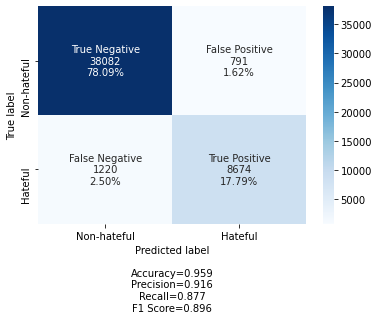

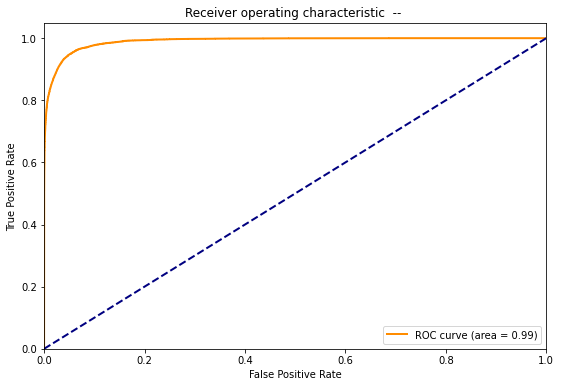

-----------------------------------------------
0.8707448746453502


In [14]:
plot_results(X_test, 0.5)

### Platform-specific performance

In [15]:
#test results on four platforms
df_twitter = X_test[X_test['Platform'] == 'Twitter']
df_wiki = X_test[X_test['Platform'] == 'Wikipedia']
df_reddit = X_test[X_test['Platform'] == 'Reddit']
df_youtube = X_test[X_test['Platform'] == 'YouTube']


F1 Score : 0.969
AUC : 0.984


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


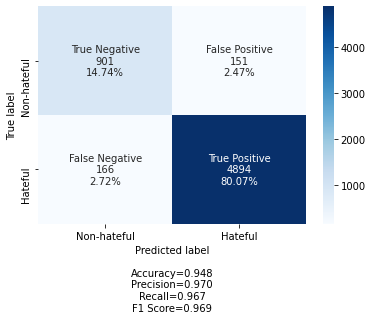

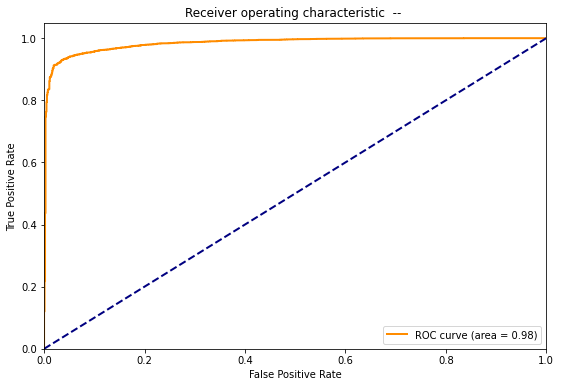

-----------------------------------------------
0.8190624559442957


In [16]:
plot_results(df_twitter, 0.5)


F1 Score : 0.901
AUC : 0.955


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


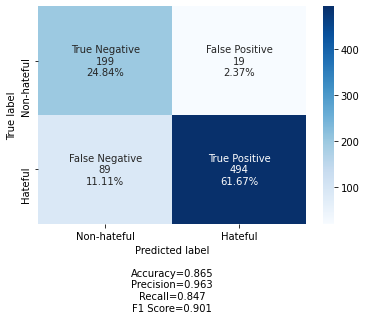

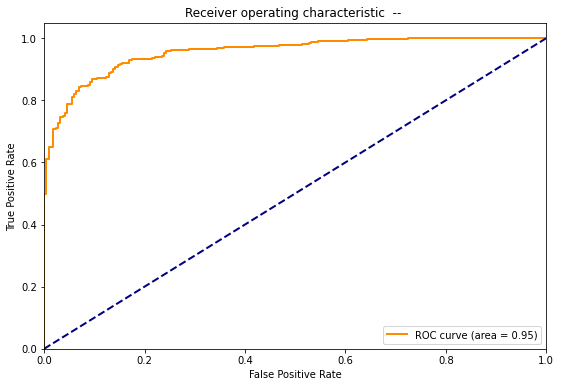

-----------------------------------------------
0.7050616736975168


In [17]:
plot_results(df_youtube, 0.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  



F1 Score : 0.816
AUC : 0.985


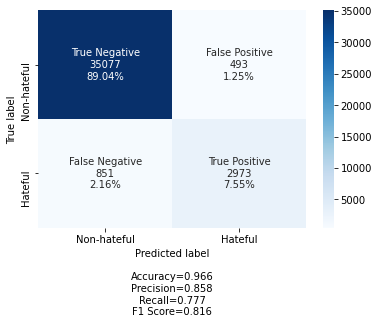

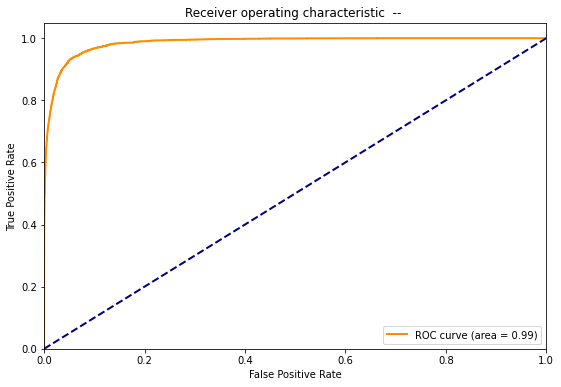

-----------------------------------------------
0.798058908813778


In [18]:
plot_results(df_wiki, 0.5)


F1 Score : 0.721
AUC : 0.95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


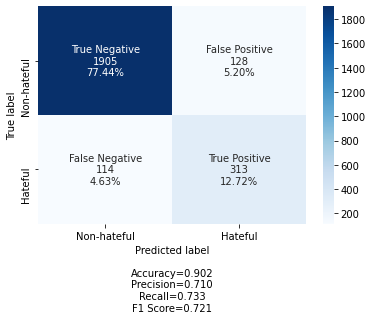

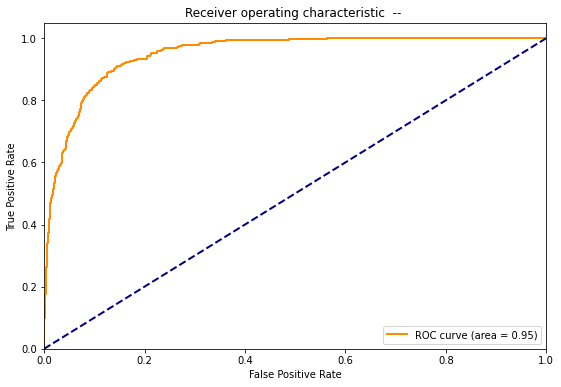

-----------------------------------------------
0.6616203035636284


In [19]:
plot_results(df_reddit, 0.5)

### Retrain optimal model on all data

In [ ]:
print('Retrain optimal model on all data.')
X_train = pd.concat([X_train, X_test])

In [ ]:
best_xgb_model = xgb.XGBRegressor(learning_rate=hyper_df['learning_rate'][0],
                                  objective='binary:logistic',
                                  random_state=25,
                                  n_jobs=8,
                                  n_estimators=hyper_df['n_estimators'][0],
                                  max_depth=hyper_df['max_depth'][0],
                                  subsample=hyper_df['subsample'][0],
                                  colsample_bytree=hyper_df['colsample_bytree'][0])

In [ ]:
best_xgb_model.fit(X_train.loc[:, bert_features], X_train['Hateful_or_not'])

/usr/local/lib/python3.7/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9600536836771764, gamma=0,
             importance_type='gain', learning_rate=0.08312197169332743,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=116, n_jobs=8, nthread=None,
             objective='binary:logistic', random_state=25, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1.0, verbosity=1)

In [ ]:
joblib.dump(best_xgb_model, final_model_path)

['/content/drive/My Drive/AIandLaw/CodeAndModel/xgboost_model.dat']